# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5 - Phase 2


---
__Group Members:__  
*Jim Chen, Memphis, TN, jim.chen@ischool.berkeley.edu*  
*Manuel Moreno, Salt Lake City, UT, momoreno@ischool.berkeley.edu*  
*Rahul Ragunathan, Lansing, MI, rahulragunathan@ischool.berkeley.edu*  
*Jason Sanchez, San Francisco, CA, jason.sanchez@ischool.berkeley.edu*  
__Class:__ MIDS w261 Fall 2016 Group 2  
__Week:__   5

__Due Time:__ 2 Phases. 

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as AltaScale's PaaS or on AWS) and is due Tuesday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the AltaScale cluster and will be due Tuesday, Week 7 by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. This will be a group exercise 


<a name="1">
# Instructions </a>

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #5

Version 2016-09-25 

 === INSTRUCTIONS for SUBMISSIONS ===
Follow the instructions for submissions carefully.

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.

# Table of Contents <a name="TOC"></a> 

* [HW5.0](#1.0): Short answers  
* [HW5.1](#1.1): Short answers  
* [HW5.2](#1.2): Joins  
* [Phase 1](#1.3): (Local) System Test  
    * [HW5.3](#1.3)   
* [Phase 2](#2.0)  
    * [Vocab Identification](#2.1)  
    * [Stripe Creation](#2.2)  
    * [InvertIndex Creation](#2.3)  
    * [Similarity Calculation](#2.4)   
    * [Ngram Ranking and Plotting](#2.5)  
    * [NLTK Benchmarking](#2.6)   
[HW5.4](#1.4)    
[HW5.5](#1.5)    
[HW5.6](#1.6)    
[HW5.7](#1.7)    
[HW5.8](#1.8)    
[HW5.9](#1.9)

<a name="2">
# HW Problems
[Back to Table of Contents](#TOC)

## HW5.0  <a name="1.0"></a>
[Back to Table of Contents](#TOC)

- What is a data warehouse? What is a Star schema? When is it used?

Data warehouse: Stores a large amount of relational, semi-structured, and unstructured data. Is used for business intelligence and data science.

A star schema has fact tables and many dimension tables that connect to the fact tables. Fact tables record events such as sales or website visits and encodes details of the events as keys (user_id, product_id, store_id, ad_id). The dimension tables store the detailed information about each of these keys. 

Star schemas provide simple approached to structuring data warehouses in a relational way.

## HW5.1  <a name="1.1"></a>
[Back to Table of Contents](#TOC)

- In the database world What is 3NF? Does machine learning use data in 3NF? If so why? 
- In what form does ML consume data?
- Why would one use log files that are denormalized?

3NF means third normal form. It is used to transform large flat files that have repeated data into a linked collection of smaller tables that can be joined on a set of common keys.

Machine learning does not use data in 3NF. Instead it uses large flat files so the details that are hidden by the keys can be used in the algorithms.

Log files can track specific events of interest. A denormalized log file allows a company to track these events in real time conditioned on specific customer features. Alternatively, a model can be running that triggers appropriate responses based on the next predicted action of a user given the user's latest action.

## HW5.2  <a name="1.2"></a>
[Back to Table of Contents](#TOC)

Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

- (1) Left joining Table Left with Table Right
- (2) Right joining Table Left with Table Right
- (3) Inner joining Table Left with Table Right

List data files to use for joins

In [20]:
!ls | grep "mo"

anonymous-msweb-preprocessed.data
mostFrequentVisitors.txt


Count lines in log dataset. View the first 10 lines. Rename data to log.txt

In [21]:
!wc -l anonymous-msweb-preprocessed.data && echo
!head anonymous-msweb-preprocessed.data
!cp anonymous-msweb-preprocessed.data log.txt

   98654 anonymous-msweb-preprocessed.data

V,1000,1,C,10001
V,1001,1,C,10001
V,1002,1,C,10001
V,1001,1,C,10002
V,1003,1,C,10002
V,1001,1,C,10003
V,1003,1,C,10003
V,1004,1,C,10003
V,1005,1,C,10004
V,1006,1,C,10005


Convert the output of 4.4 to be just url and url_id. Save as urls.txt.

In [22]:
!cat mostFrequentVisitors.txt | cut -f 1,2 -d',' > urls.txt
!wc -l urls.txt && echo
!head urls.txt

     285 urls.txt

"/regwiz",1000
"/support",1001
"/athome",1002
"/kb",1003
"/search",1004
"/norge",1005
"/misc",1006
"/ie_intl",1007
"/msdownload",1008
"/windows",1009


The urls.txt file is much smaller than the log.txt data and should be what is loaded into memory. This means it would be the right-side table in a left-side join.

In [117]:
%%writefile join.py

from mrjob.job import MRJob
from mrjob.step import MRStep

# Avoid broken pipe error
from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE,SIG_DFL) 

class Join(MRJob):
    def configure_options(self):
        super(Join, self).configure_options()
        
        self.add_passthrough_option(
            '--join', 
            default="left", 
            help="Options: left, inner, right")
        
    def mapper_init(self):
        self.join = self.options.join
        self.urls_used = set()
        self.urls = {}
        
        try:
            open("urls.txt")
            filename = "urls.txt"
        except FileNotFoundError:
            filename = "limited_urls.txt"
        
        with open(filename) as urls:
            for line in urls:
                url, key = line.strip().replace('"',"").split(",")
                self.urls[key] = url
        
    def mapper(self, _, lines):
        try:
            url = lines[2:6]
            if self.join in ["inner", "left"]:
                yield (lines, self.urls[url])
            elif self.join in ["right"]:
                yield (self.urls[url], lines)
                self.urls_used.add(url)
            
        except KeyError:
            if self.join in ["inner", "right"]:
                pass
            else:
                yield (lines, "None")

    def mapper_final(self):
        for key, value in self.urls.items():
            if key not in self.urls_used:
                yield (self.urls[key], "*")
                
    def reducer(self, url, values):
        quick_stash = 0
        for val in values:
            if val != "*":
                quick_stash += 1
                yield (val, url)
        if quick_stash == 0:
            yield ("None", url)
            
    def steps(self):
        join = self.options.join
        if join in ["inner", "left"]:
            mrsteps = [MRStep(mapper_init=self.mapper_init,
                              mapper=self.mapper)]
        if join == "right":
            mrsteps = [MRStep(mapper_init=self.mapper_init,
                              mapper=self.mapper,
                              mapper_final=self.mapper_final,
                              reducer=self.reducer)]  
        return mrsteps
        
if __name__ == "__main__":
    Join.run()

Overwriting join.py


Make a file with only the first five urls to test left and inner join.

In [128]:
!head -n 5 urls.txt > limited_urls.txt

Using the first ten lines of the log file and left joining it to the first five lines of the urls file, we see that some of the urls are returned as "None." This is correct behavior.

In [141]:
!head log.txt | python join.py --file limited_urls.txt --join left -q

"V,1000,1,C,10001"	"/regwiz"
"V,1001,1,C,10001"	"/support"
"V,1002,1,C,10001"	"/athome"
"V,1001,1,C,10002"	"/support"
"V,1003,1,C,10002"	"/kb"
"V,1001,1,C,10003"	"/support"
"V,1003,1,C,10003"	"/kb"
"V,1004,1,C,10003"	"/search"
"V,1005,1,C,10004"	"None"
"V,1006,1,C,10005"	"None"


Performing the same operation, but with an inner join, we see the lines that were "None" are dropped.

In [130]:
!head log.txt | python join.py --file limited_urls.txt --join inner -q

"V,1000,1,C,10001"	"/regwiz"
"V,1001,1,C,10001"	"/support"
"V,1002,1,C,10001"	"/athome"
"V,1001,1,C,10002"	"/support"
"V,1003,1,C,10002"	"/kb"
"V,1001,1,C,10003"	"/support"
"V,1003,1,C,10003"	"/kb"
"V,1004,1,C,10003"	"/search"


To prove the right-side join works, we can only use the first 100 log entries. We see that urls without corresponding log entries are listed as "None" and that all urls are returned in alphabetical order.

In [140]:
!head -n 100 log.txt | python join.py --file urls.txt --join right -r local -q | head -n 15

"None"	"/access"
"None"	"/accessdev"
"None"	"/activeplatform"
"None"	"/activex"
"None"	"/adc"
"None"	"/ado"
"None"	"/ads"
"None"	"/advtech"
"None"	"/argentina"
"None"	"/atec"
"V,1002,1,C,10001"	"/athome"
"V,1002,1,C,10019"	"/athome"
"V,1002,1,C,10020"	"/athome"
"V,1002,1,C,10031"	"/athome"
"None"	"/australia"


By using the limited urls file, we see that only five urls are returned and every logged page visit to those pages are returned (at least within the first 50 log entries).

In [139]:
!head -n 50 log.txt | python join.py --file limited_urls.txt --join right -r local -q

"V,1002,1,C,10001"	"/athome"
"V,1002,1,C,10019"	"/athome"
"V,1003,1,C,10002"	"/kb"
"V,1003,1,C,10003"	"/kb"
"V,1003,1,C,10006"	"/kb"
"V,1003,1,C,10019"	"/kb"
"V,1000,1,C,10001"	"/regwiz"
"V,1000,1,C,10010"	"/regwiz"
"V,1004,1,C,10003"	"/search"
"V,1004,1,C,10006"	"/search"
"V,1004,1,C,10008"	"/search"
"V,1004,1,C,10018"	"/search"
"V,1004,1,C,10019"	"/search"
"V,1001,1,C,10001"	"/support"
"V,1001,1,C,10002"	"/support"
"V,1001,1,C,10003"	"/support"


# HW5.3 <a name="1.3"></a> Systems tests on n-grams dataset (Phase1) and full experiment (Phase 2)
[Back to Table of Contents](#TOC)

## 3.  HW5.3.0 Run Systems tests locally (PHASE1)
[Back to Table of Contents](#TOC)

A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox and on s3:

https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

s3://filtered-5grams/

In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

The next cell shows the first 10 lines of the googlebooks-eng-all-5gram-20090715-0-filtered.txt file.


__DISCLAIMER__: Each record is already a 5-gram. We should calculate the stripes cooccurrence data from the raw text and not from the 5-gram preprocessed data. Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms. 

### Data for systems test

mini_5gram.txt

In [149]:
%%writefile mini_5gram.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Writing mini_5gram.txt


atlas.txt

In [150]:
%%writefile atlas.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Overwriting atlas.txt


mini_stripes.txt

In [151]:
with open("mini_stripes.txt", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat mini_stripes.txt 

"DocA"	{"X":20, "Y":30, "Z":5}
"DocB"	{"X":100, "Y":20}
"DocC"	{"M":5, "N":20, "Z":5, "Y":1}


## TASK: Phase 1
Complete 5.4 and 5.5 and systems test them using the above test datasets. Phase 2 will focus on the entire Ngram dataset.

To help you through these tasks please verify that your code gives the following results (for stripes, inverted index, and pairwise similarities).

### Make stripes

In [161]:
%%writefile MakeStripes.py

from mrjob.job import MRJob
from collections import Counter

class MakeStripes(MRJob):
    def mapper(self, _, lines):
        terms, term_count, page_count, book_count = lines.split("\t")
        terms = terms.split()
        term_count = int(term_count)
        
        for item in terms:
            yield (item, {term:term_count for term in terms if term != item})
        
    def combiner(self, keys, values):
        values_sum = Counter()
        for val in values:
            values_sum += Counter(val)
        yield keys, dict(values_sum)

    def reducer(self, keys, values):
        values_sum = Counter()
        for val in values:
            values_sum += Counter(val)
        yield keys, dict(values_sum)
        
if __name__ == "__main__":
    MakeStripes.run()

Overwriting MakeStripes.py


#### Desired result

In [164]:
%%writefile atlas_desired_results.txt

"atlas"	{"dipped": 15, "boon": 50}
"boon"	{"atlas": 50, "dipped": 10, "cava": 10}
"cava"	{"dipped": 10, "boon": 10}
"dipped"	{"atlas": 15, "boon": 10, "cava": 10}

Writing atlas_desired_results.txt


#### Actual result

In [168]:
!cat atlas-boon-systems-test.txt | python MakeStripes.py -q > atlas_stripes.txt
!cat atlas_stripes.txt

"atlas"	{"dipped": 15, "boon": 50}
"boon"	{"atlas": 50, "dipped": 10, "cava": 10}
"cava"	{"dipped": 10, "boon": 10}
"dipped"	{"atlas": 15, "boon": 10, "cava": 10}


Actual result matches desired result

## Inverted index

In [169]:
%%writefile InvertIndex.py

from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from collections import Counter

class InvertIndex(MRJob):
    MRJob.input_protocol = JSONProtocol
    
    def mapper(self, key, words):
        n_words = len(words)
        
        for word in words: 
            yield (word, {key:n_words})
            
    def combiner(self, keys, values):
        values_sum = Counter()
        for val in values:
            values_sum += Counter(val)
        yield keys, dict(values_sum)

    def reducer(self, keys, values):
        values_sum = Counter()
        for val in values:
            values_sum += Counter(val)
        yield keys, dict(values_sum)
        
if __name__ == "__main__":
    InvertIndex.run()

Overwriting InvertIndex.py


#### Desired result

Systems test mini_stripes - Inverted Index   
——————————————————————————————————————————   
            "M" |         DocC 4 |          
            "N" |         DocC 4 |           
            "X" |         DocA 3 |         DocB 2 |               
            "Y" |         DocA 3 |         DocB 2 |         DocC 4   |   
            "Z" |         DocA 3 |         DocC 4 |               

 systems test atlas-boon - Inverted Index   
——————————————————————————————————————————   
        "atlas" |         boon 3 |       dipped 3 |               
       "dipped" |        atlas 2 |         boon 3 |         cava 2  |  
         "boon" |        atlas 2 |         cava 2 |       dipped 3  |  
         "cava" |         boon 3 |       dipped 3 |        

#### Actual result

In [170]:
!cat mini_stripes.txt | python InvertIndex.py -q > mini_stripes_inverted.txt
!cat mini_stripes_inverted.txt

"M"	{"DocC": 4}
"N"	{"DocC": 4}
"X"	{"DocA": 3, "DocB": 2}
"Y"	{"DocC": 4, "DocA": 3, "DocB": 2}
"Z"	{"DocC": 4, "DocA": 3}


In [171]:
!cat atlas_stripes.txt | python InvertIndex.py -q > atlas_inverted.txt
!cat atlas_inverted.txt

"atlas"	{"dipped": 3, "boon": 3}
"boon"	{"dipped": 3, "atlas": 2, "cava": 2}
"cava"	{"dipped": 3, "boon": 3}
"dipped"	{"atlas": 2, "boon": 3, "cava": 2}


The tests pass

## Similarity

In [172]:
%%writefile Similarity.py

from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from itertools import combinations
from statistics import mean

class Similarity(MRJob):
    MRJob.input_protocol = JSONProtocol
    
    def mapper(self, key_term, docs):
        doc_names = docs.keys()
        for doc_pairs in combinations(sorted(list(doc_names)), 2):
            yield (doc_pairs, 1)
        for name in doc_names:
            yield (name, 1)
            
    def combiner(self, key, value):
        yield (key, sum(value))
        
    def reducer_init(self):
        self.words = {}
        self.results = []
    
    def reducer(self, doc_or_docs, count):
        if isinstance(doc_or_docs, str):
            self.words[doc_or_docs] = sum(count)
        else:
            d1, d2 = doc_or_docs
            d1_n_words, d2_n_words = self.words[d1], self.words[d2]
            intersection = sum(count)
            
            jaccard = round(intersection/(d1_n_words + d2_n_words - intersection), 3)
            cosine = round(intersection/(d1_n_words**.5 * d2_n_words**.5), 3)
            dice = round(2*intersection/(d1_n_words + d2_n_words), 3)
            overlap = round(intersection/min(d1_n_words, d2_n_words), 3)
            average = round(mean([jaccard, cosine, dice, overlap]), 3)
            
            self.results.append([doc_or_docs, {"jacc":jaccard, "cos":cosine, 
                                               "dice":dice, "ol":overlap, "ave":average}])
            
    def reducer_final(self):
        for doc, result in sorted(self.results, key=lambda x: x[1]["ave"], reverse=True):
            yield (doc, result)
        
if __name__ == "__main__":
    Similarity.run()

Overwriting Similarity.py


#### Desired results

Systems test mini_stripes - Similarity measures

| average |           pair |         cosine |        jaccard |        overlap |           dice |
|-|-|-|-|-|-|
|       0.741582 |    DocA - DocB |       0.816497 |       0.666667 |       1.000000 |       0.800000 |
|       0.488675 |    DocA - DocC |       0.577350 |       0.400000 |       0.666667 |       0.571429 |
|       0.276777 |    DocB - DocC |       0.353553 |       0.200000 |       0.500000 |       0.333333 |




Systems test atlas-boon 2 - Similarity measures

| average |           pair |         cosine |        jaccard |        overlap |           dice |
|-|-|-|-|-|-|       
|1.000000 |   atlas - cava |       1.000000 |       1.000000 |        1.000000 |       1.000000|
|       0.625000 |  boon - dipped |       0.666667 |       0.500000 |       0.666667 |       0.666667|
|       0.389562 |  cava - dipped |       0.408248 |       0.250000 |       0.500000 |       0.400000|
|       0.389562 |    boon - cava |       0.408248 |       0.250000 |       0.500000 |       0.400000|
|       0.389562 | atlas - dipped |       0.408248 |       0.250000 |       0.500000 |       0.400000|
|       0.389562 |   atlas - boon |       0.408248 |       0.250000 |       0.500000 |       0.400000|

#### Actual results

In [173]:
!cat mini_stripes_inverted.txt | python Similarity.py -q --jobconf mapred.reduce.tasks=1

["DocA", "DocB"]	{"cos": 0.816, "ave": 0.821, "jacc": 0.667, "dice": 0.8, "ol": 1.0}
["DocA", "DocC"]	{"cos": 0.577, "ave": 0.554, "jacc": 0.4, "dice": 0.571, "ol": 0.667}
["DocB", "DocC"]	{"cos": 0.354, "ave": 0.347, "jacc": 0.2, "dice": 0.333, "ol": 0.5}


In [179]:
!cat atlas_inverted.txt | python Similarity.py -q --jobconf mapred.reduce.tasks=1

["atlas", "cava"]	{"ol": 1.0, "jacc": 1.0, "cos": 1.0, "ave": 1.0, "dice": 1.0}
["boon", "dipped"]	{"ol": 0.667, "jacc": 0.5, "cos": 0.667, "ave": 0.625, "dice": 0.667}
["atlas", "boon"]	{"ol": 0.5, "jacc": 0.25, "cos": 0.408, "ave": 0.39, "dice": 0.4}
["atlas", "dipped"]	{"ol": 0.5, "jacc": 0.25, "cos": 0.408, "ave": 0.39, "dice": 0.4}
["boon", "cava"]	{"ol": 0.5, "jacc": 0.25, "cos": 0.408, "ave": 0.39, "dice": 0.4}
["cava", "dipped"]	{"ol": 0.5, "jacc": 0.25, "cos": 0.408, "ave": 0.39, "dice": 0.4}


The numbers calculated exactly match the systems test except for the average calculations of the mini_stripes set. In this instance, the systems test calculations are not correct.

#### From beginning to end

In [177]:
!cat atlas-boon-systems-test.txt | python MakeStripes.py -q | python InvertIndex.py -q | python Similarity.py -q --jobconf mapred.reduce.tasks=1

["atlas", "cava"]	{"ave": 1.0, "jacc": 1.0, "ol": 1.0, "dice": 1.0, "cos": 1.0}
["boon", "dipped"]	{"ave": 0.625, "jacc": 0.5, "ol": 0.667, "dice": 0.667, "cos": 0.667}
["atlas", "boon"]	{"ave": 0.39, "jacc": 0.25, "ol": 0.5, "dice": 0.4, "cos": 0.408}
["atlas", "dipped"]	{"ave": 0.39, "jacc": 0.25, "ol": 0.5, "dice": 0.4, "cos": 0.408}
["boon", "cava"]	{"ave": 0.39, "jacc": 0.25, "ol": 0.5, "dice": 0.4, "cos": 0.408}
["cava", "dipped"]	{"ave": 0.39, "jacc": 0.25, "ol": 0.5, "dice": 0.4, "cos": 0.408}


<a name="2.0">
# PHASE 2: Full-scale experiment on Google N-gram data

<a name="2.1">
## 2.1 Vocab Identification
[Back to Table of Contents](#TOC)  

This section scans through the corpus file(s) and identify the top-n frequent words as vocabularies.

We utilize heapq to reduce the amount of data to transfer using hadoop. 

This approach can run into memory constraints if our goal is to return the top k results where k is so large the resulting ordered list cannot fit into memory on a single machine (i.e. billions of results). In practice, we only care about a small number of the top results (for example, in this problem we only need to return the top 1000 results. 1000 results are trivially stored in memory).

The code uses multiple reducers. In the last MapReduce step, all data is sent to a single reducer by use of a single key; however, the data that is sent is never stored in memory (only the top k results are) and at most k*n_reducers observations would be sent to this reducer, which means the total data sent is very small and could easily fit on a single hard drive. If the data is so large it cannot fit on a single hard drive, we could add more MR steps to reduce the size of the data by 90% for each added step. 

That said, we estimate that the code could work without any changes on a dataset with 100 trillion words if we were asked to return the top 100,000 words and had a cluster of 1,000 machines available.

In [142]:
%%writefile GetIndexandOtherWords.py

import heapq
from re import findall
from mrjob.job import MRJob
from mrjob.step import MRStep


class TopList(list):
    def __init__(self, max_size, num_position=0):
        """
        Just like a list, except the append method adds the new value to the 
        list only if it is larger than the smallest value (or if the size of 
        the list is less than max_size). 
        
        If each element of the list is an int or float, uses that value for 
        comparison. If the elements in the list are lists or tuples, uses the 
        list_position element of the list or tuple for the comparison.
        """
        self.max_size = max_size
        self.pos = num_position
        
    def _get_key(self, x):
        return x[self.pos] if isinstance(x, (list, tuple)) else x
        
    def append(self, val):
        if len(self) < self.max_size:
            heapq.heappush(self, val)
        elif self._get_key(self[0]) < self._get_key(val):
            heapq.heapreplace(self, val)
            
    def final_sort(self):
        return sorted(self, key=self._get_key, reverse=True)

    
class GetIndexandOtherWords(MRJob):
    """
    Usage: python GetIndexandOtherWords.py --index-range 9000-10000 --top-n-words 10000 --use-term-counts True
    
    Given n-gram formatted data, outputs a file of the form:
    
    index    term
    index    term
    ...
    word     term
    word     term
    ...
    
    Where there would be 1001 index words and 10000 total words. Each word would be ranked based
    on either the term count listed in the Google n-gram data (i.e. the counts found in the
    underlying books) or the ranks would be based on the word count of the n-grams in the actual
    dataset (i.e. ignore the numbers/counts associated with each n-gram and count each n-gram
    exactly once).
    """
    def configure_options(self):
        super(GetIndexandOtherWords, self).configure_options()
        
        self.add_passthrough_option(
            '--index-range', 
            default="9-10", 
            help="Specify the range of the index words. ex. 9-10 means the ninth and " +
                 "tenth most popular words will serve as the index")
        
        self.add_passthrough_option(
            '--top-n-words', 
            default="10", 
            help="Specify the number of words to output in all")
        
        self.add_passthrough_option(
            '--use-term-counts', 
            default="True", 
            choices=["True","False"],
            help="When calculating the most frequent words, choose whether to count " + 
            "each word based on the term counts reported by Google or just based on " + 
            "the number of times the word appears in an n-gram")
        
        self.add_passthrough_option(
            '--return-counts', 
            default="False", 
            choices=["True","False"],
            help="The final output includes the counts of each word")
        
    def mapper_init(self):
        # Ensure command line options are sane
        top_n_words = int(self.options.top_n_words)
        last_index_word = int(self.options.index_range.split("-")[1])
        if top_n_words < last_index_word:
            raise ValueError("""--top-n-words value (currently %d) must be equal to or greater than
                             --index-range value (currently %d).""" % (top_n_words, last_index_word))
        
        self.stop_words =  set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
                            'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 
                            'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 
                            'its', 'itself', 'they', 'them', 'their', 'theirs', 
                            'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
                            'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
                            'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
                            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                            'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
                            'with', 'about', 'against', 'between', 'into', 'through', 
                            'during', 'before', 'after', 'above', 'below', 'to', 'from', 
                            'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
                            'again', 'further', 'then', 'once', 'here', 'there', 'when', 
                            'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 
                            'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
                            'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 
                            'can', 'will', 'just', 'don', 'should', 'now'])
        
    def mapper(self, _, lines):
        terms, term_count, page_count, book_count = lines.split("\t")
        
        # Either use the ngram term count for the count or count each word just once
        if self.options.use_term_counts == "True":
            term_count = int(term_count)
        else:
            term_count = 1
        
        # Iterate through each term. Skip stop words
        for term in findall(r'[a-z]+', terms.lower()):
            if term in self.stop_words:
                pass
            else:
                yield (term, term_count)
        
    def combiner(self, term, counts):
        yield (term, sum(counts))      
        
        
    def reducer_init(self):
        """
        Accumulates the top X words and yields them. Note: should only use if
        you want to emit a reasonable amount of top words (i.e. an amount that 
        could fit on a single computer.)
        """
        self.top_n_words = int(self.options.top_n_words)
        self.TopTerms = TopList(self.top_n_words, num_position=1)
        
    def reducer(self, term, counts):
        self.TopTerms.append((term, sum(counts)))

    def reducer_final(self):
        for pair in self.TopTerms:
            yield pair
        
    def mapper_single_key(self, term, count):
        """
        Send all the data to a single reducer
        """
        yield (1, (term, count))
        
    def reducer_init_top_vals(self):
        # Collect top words
        self.top_n_words = int(self.options.top_n_words)
        self.TopTerms = TopList(self.top_n_words, num_position=1)
        # Collect index words
        self.index_range = [int(num) for num in self.options.index_range.split("-")]
        self.index_low, self.index_high = self.index_range
        # Control if output shows counts or just words
        self.return_counts = self.options.return_counts == "True"

    def reducer_top_vals(self, _, terms):
        for term in terms:
            self.TopTerms.append(term)
            
    def reducer_final_top_vals(self):
        TopTerms = self.TopTerms.final_sort()
        
        if self.return_counts:            
            # Yield index words
            for term in TopTerms[self.index_low-1:self.index_high]:
                yield ("index", term)

            # Yield all words
            for term in TopTerms:
                yield ("words", term)
        else:
            # Yield index words
            for term in TopTerms[self.index_low-1:self.index_high]:
                yield ("index", term[0])

            # Yield all words
            for term in TopTerms:
                yield ("words", term[0])
    
    def steps(self):
        """
        Step one: Yield top n-words from each reducer. Means dataset size is 
                  n-words * num_reducers. Guarantees overall top n-words are 
                  sent to the next step.
        
        """
        mr_steps = [MRStep(mapper_init=self.mapper_init,
                           mapper=self.mapper,
                           combiner=self.combiner,
                           reducer_init=self.reducer_init,
                           reducer_final=self.reducer_final,
                           reducer=self.reducer),
                    MRStep(mapper=self.mapper_single_key,
                           reducer_init=self.reducer_init_top_vals,
                           reducer=self.reducer_top_vals,
                           reducer_final=self.reducer_final_top_vals)]
        return mr_steps
        
if __name__ == "__main__":
    GetIndexandOtherWords.run()

Overwriting GetIndexandOtherWords.py


Test getting the index and other valid words excluding stop words on the mini_5gram.txt dataset. Return the top 10 most common words (based on the term counts) and mark the ninth and tenth most common words as the index words.

In [218]:
!cat mini_5gram.txt | python GetIndexandOtherWords.py --index-range 16-20    \
                                                      --top-n-words 20       \
                                                      --return-counts False  \
                                                      --use-term-counts True \
                                                       -q > vocabs
!cat vocabs

"index"	"narrative"
"index"	"sea"
"index"	"establishing"
"index"	"religious"
"index"	"limited"
"words"	"child"
"words"	"christmas"
"words"	"wales"
"words"	"case"
"words"	"study"
"words"	"female"
"words"	"collection"
"words"	"fairy"
"words"	"tales"
"words"	"forms"
"words"	"government"
"words"	"general"
"words"	"george"
"words"	"circumstantial"
"words"	"city"
"words"	"narrative"
"words"	"sea"
"words"	"establishing"
"words"	"religious"
"words"	"limited"


To spot check the results, view the term counts of each word.

In [221]:
!cat mini_5gram.txt | python GetIndexandOtherWords.py --index-range 16-20    \
                                                      --top-n-words 20       \
                                                      --return-counts True   \
                                                      --use-term-counts True \
                                                       -q

"index"	["narrative", 62]
"index"	["sea", 62]
"index"	["establishing", 59]
"index"	["religious", 59]
"index"	["limited", 55]
"words"	["child", 1099]
"words"	["christmas", 1099]
"words"	["wales", 1099]
"words"	["case", 604]
"words"	["study", 604]
"words"	["female", 447]
"words"	["collection", 239]
"words"	["fairy", 123]
"words"	["tales", 123]
"words"	["forms", 116]
"words"	["government", 102]
"words"	["general", 92]
"words"	["george", 92]
"words"	["circumstantial", 62]
"words"	["city", 62]
"words"	["narrative", 62]
"words"	["sea", 62]
"words"	["establishing", 59]
"words"	["religious", 59]
"words"	["limited", 55]


## 3.  HW5.3.2  Full-scale experiment: EDA of Google n-grams dataset (PHASE 2)
[Back to Table of Contents](#TOC)

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

We included all of this analysis at the end.

See [here](#2.5).

<a name="2.2">
## 2.2 Stripe Creation
[Back to Table of Contents](#TOC)  

The section takes the output from 2.1 and create stripes based on the vocabularies identified.  

In [223]:
%%writefile MakeStripes.py

from mrjob.job import MRJob
from collections import Counter
from sys import stderr
from re import findall

class MakeStripes(MRJob):
    def mapper_init(self):
        """
        Read in index words and word list.
        """
        self.stripes = {}
        
        self.indexlist, self.wordslist = [],[]
        with open('vocabs', 'r') as vocabFile:
            for line in vocabFile:
                word_type, word = line.replace('"', '').split()
                if word_type == 'index':
                    self.indexlist.append(word)
                else:
                    self.wordslist.append(word)
        
        # Convert to sets to make lookups faster
        self.indexlist = set(self.indexlist)
        self.wordslist = set(self.wordslist)
    
    def mapper(self, _, lines):
        """
        Make stripes using index and words list
        """
        terms, term_count, page_count, book_count = lines.split("\t")
        term_count = int(term_count)
        terms = findall(r'[a-z]+', terms.lower())
                
        for item in terms:
            if item in self.indexlist:
                for val in terms:
                    if val != item and val in self.wordslist:
                        yield item, {val:term_count}
        
    def combiner(self, keys, values):
        values_sum = Counter()
        for val in values:
            values_sum += Counter(val)
        yield keys, dict(values_sum)

    def reducer(self, keys, values):
        values_sum = Counter()
        for val in values:
            values_sum += Counter(val)
        yield keys, dict(values_sum)
        
if __name__ == "__main__":
    MakeStripes.run()

Overwriting MakeStripes.py


In [224]:
!python MakeStripes.py --file vocabs mini_5gram.txt -q

"establishing"	{"religious": 59}
"limited"	{"case": 55, "study": 55}
"narrative"	{"circumstantial": 62}
"religious"	{"establishing": 59}
"sea"	{"city": 62}


<a name="2.3">
## 2.3 Invert Index Creation
[Back to Table of Contents](#TOC)  

In [229]:
%%writefile InvertIndex.py

from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from collections import Counter

class InvertIndex(MRJob):
    MRJob.input_protocol = JSONProtocol
    
    def mapper(self, key, words):
        """
        Convert each stripe to inverted index
        """
        n_words = len(words)
        for word in words: 
            yield (word, {key:n_words})
            
    def combiner(self, keys, values):
        values_sum = Counter()
        for val in values:
            values_sum += Counter(val)
        yield keys, dict(values_sum)

    def reducer(self, keys, values):
        values_sum = Counter()
        for val in values:
            values_sum += Counter(val)
        yield keys, dict(values_sum)
        
if __name__ == "__main__":
    InvertIndex.run()

Overwriting InvertIndex.py


In [232]:
!python MakeStripes.py --file vocabs mini_5gram.txt -q | python InvertIndex.py -q

"case"	{"limited": 2}
"circumstantial"	{"narrative": 1}
"city"	{"sea": 1}
"establishing"	{"religious": 1}
"religious"	{"establishing": 1}
"study"	{"limited": 2}


<a name="2.4">
## 2.4 Similarity Calculation
[Back to Table of Contents](#TOC)  

In [233]:
%%writefile Similarity.py

from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from itertools import combinations

class Similarity(MRJob):
    MRJob.input_protocol = JSONProtocol
    
    def mapper(self, key_term, docs):
        """
        Make co-occurrence keys for each pair of documents in the inverted
        index and make keys representing each document.
        """
        doc_names = docs.keys()
        for doc_pairs in combinations(sorted(list(doc_names)), 2):
            yield (doc_pairs, 1)
        for name in doc_names:
            yield (name, 1)
            
    def combiner(self, key, value):
        yield (key, sum(value))
        
        
    ### Custom partitioner code goes here
    def reducer_init(self):
        self.words = {}
        self.results = []
    
    def reducer(self, doc_or_docs, count):
        if isinstance(doc_or_docs, str):
            self.words[doc_or_docs] = sum(count)
        else:
            d1, d2 = doc_or_docs
            d1_n_words, d2_n_words = self.words[d1], self.words[d2]
            intersection = float(sum(count))
            
            jaccard = round(intersection/(d1_n_words + d2_n_words - intersection), 3)
            cosine = round(intersection/(d1_n_words**.5 * d2_n_words**.5), 3)
            dice = round(2*intersection/(d1_n_words + d2_n_words), 3)
            overlap = round(intersection/min(d1_n_words, d2_n_words), 3)
            average = round(sum([jaccard, cosine, dice, overlap])/4.0, 3)
            
            self.results.append([doc_or_docs, {"jacc":jaccard, "cos":cosine, 
                                               "dice":dice, "ol":overlap, "ave":average}])
            
    def reducer_final(self):
        for doc, result in sorted(self.results, key=lambda x: x[1]["ave"], reverse=True):
            yield (doc, result)
        
if __name__ == "__main__":
    Similarity.run()

Overwriting Similarity.py


Doesn't return anything because there are no co-occurring words in the inverted index.

In [237]:
!python MakeStripes.py --file vocabs mini_5gram.txt -q | python InvertIndex.py -q | python Similarity.py -q --jobconf mapred.reduce.tasks=1

### Time the full calculations a slightly larger dataset

First, let's see how large the full dataset is. This number won't be exactly correct because my download was interrupted halfway through and I only have 185 items total.

In [261]:
%%time
!cat Temp_data/googlebooks-eng-all-5gram-20090715-* | wc

 57432975 459463800 2110162633
CPU times: user 126 ms, sys: 37.3 ms, total: 163 ms
Wall time: 10.6 s


Because there are 200 files that make up the 5-gram dataset (at least that is what I thought I heard), the true line count of the dataset is about:

In [263]:
int(57432975*(200/185))

62089702

We are going to operate on a subset of this data.

In [256]:
%%time
!cat Temp_data/googlebooks-eng-all-5gram-20090715-9* | wc

 3435179 27481432 126216026
CPU times: user 9.55 ms, sys: 8.13 ms, total: 17.7 ms
Wall time: 789 ms


This sample of the data is only a few percent (about 5.5%) of the full size of the dataset.

In [264]:
3435179/62089702

0.05532606679284755

#### Create index and words to use

We find that many of the index words only occur one time.

In [299]:
%%time
!cat Temp_data/googlebooks-eng-all-5gram-20090715-9* | python GetIndexandOtherWords.py --index-range 9001-10000  \
                                                                                       --top-n-words 10000       \
                                                                                       --return-counts True     \
                                                                                       --use-term-counts False    \
                                                                                        -q > vocabs
!head vocabs

"index"	["bereavements", 1]
"index"	["augmente", 1]
"index"	["berenice", 1]
"index"	["berenson", 1]
"index"	["beret", 1]
"index"	["augmentis", 1]
"index"	["bergey", 1]
"index"	["berggren", 1]
"index"	["bergs", 1]
"index"	["berkel", 1]
CPU times: user 1.32 s, sys: 357 ms, total: 1.68 s
Wall time: 2min 15s


Here we will return the term count of each word (not the 5gram-based count).

In [300]:
%%time
!cat Temp_data/googlebooks-eng-all-5gram-20090715-9* | python GetIndexandOtherWords.py --index-range 9001-10000  \
                                                                                       --top-n-words 10000       \
                                                                                       --return-counts True     \
                                                                                       --use-term-counts True    \
                                                                                        -q > vocabs
!head vocabs

"index"	["averil", 63]
"index"	["bioreactor", 63]
"index"	["bjork", 63]
"index"	["blankest", 63]
"index"	["blatea", 63]
"index"	["blazon", 63]
"index"	["badajos", 63]
"index"	["ballantynes", 63]
"index"	["bantered", 63]
"index"	["brandenburgh", 63]
CPU times: user 1.52 s, sys: 399 ms, total: 1.92 s
Wall time: 2min 22s


This code is very similar to what we would run on the full dataset

In [303]:
%%time
!cat Temp_data/googlebooks-eng-all-5gram-20090715-9* | python GetIndexandOtherWords.py --index-range 9001-10000  \
                                                                                       --top-n-words 10000       \
                                                                                       --return-counts False     \
                                                                                       --use-term-counts True    \
                                                                                        -q > vocabs
!head vocabs

"index"	"averil"
"index"	"bioreactor"
"index"	"bjork"
"index"	"blankest"
"index"	"blatea"
"index"	"blazon"
"index"	"badajos"
"index"	"ballantynes"
"index"	"bantered"
"index"	"brandenburgh"
CPU times: user 1.29 s, sys: 353 ms, total: 1.64 s
Wall time: 2min 16s


Make stripes, invert index, and calculate similarities. Print top similarities.

In [315]:
%%time
!cat Temp_data/googlebooks-eng-all-5gram-20090715-9* | python MakeStripes.py --file vocabs -q | python InvertIndex.py -q | python Similarity.py -q --jobconf mapred.reduce.tasks=1 > similarities.txt
!head similarities.txt

["aufalle", "aufbau"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufalle", "aufgaben"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufalle", "auftrag"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufalle", "auftrage"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufalle", "ausgrabungen"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufalle", "baues"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufalle", "bayerischen"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufalle", "bearbeitung"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufalle", "bildende"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
["aufbau", "aufgaben"]	{"cos": 1.0, "ol": 1.0, "jacc": 1.0, "ave": 1.0, "dice": 1.0}
CPU times: user 219 ms, sys: 66.3 ms, total: 285 ms
Wall time: 22.7 s


It about 3 minutes to run this code. The code processes 11 out of 200 files. It currently uses one machine. If the cluster has 50 machines available, we would expect it to take only a few minutes for these core operations to run.

In [316]:
minutes_for_small_job = 3
n_small_jobs_in_big_job = 200/11
total_minutes_one_computer = minutes_for_small_job*n_small_jobs_in_big_job
computers_in_cluster = 50
total_minutes_for_cluster = total_minutes_one_computer/computers_in_cluster
total_minutes_for_cluster

1.0909090909090908

# Experimental code on custom partitioner

In [331]:
from string import ascii_letters
ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [333]:
chr(65)

'A'

In [387]:
%%writefile CustomPartitioner.py

from mrjob.job import MRJob
from sys import stderr
import numpy as np
from operator import itemgetter
from random import random


class CustomPartitioner(MRJob):
    def __init__(self, *args, **kwargs):
        super(CustomPartitioner, self).__init__(*args, **kwargs)
        self.N = 30
        self.NUM_REDUCERS = 2

    def mapper_init(self):

        def makeKeyHash(key, num_reducers):
            byteof = lambda char: int(format(ord(char), 'b'), 2)
            current_hash = 0
            for c in key:
                current_hash = (current_hash * 31 + byteof(c))
            return current_hash % num_reducers

        # printable ascii characters, starting with 'A'
        keys = [str(chr(i)) for i in range(65,65+self.NUM_REDUCERS)]
        partitions = []

        for key in keys:
            partitions.append([key, makeKeyHash(key, self.NUM_REDUCERS)])

        parts = sorted(partitions,key=itemgetter(1))
        self.partition_keys = list(np.array(parts)[:,0])

        self.partition_file = np.arange(0,self.N,self.N/(self.NUM_REDUCERS))[::-1]
        
        print((keys, partitions, parts, self.partition_keys, self.partition_file), file=stderr)

        
    def mapper(self, _, lines):
        terms, term_count, page_count, book_count = lines.split("\t")
        terms = terms.split()
        term_count = int(term_count)
        
        for item in terms:
            yield (item, term_count)
            
        for item in ["A", "B", "H", "I"]:
            yield (item, 0)
            
    def reducer_init(self):
        self.reducer_unique_key = round(random(), 5)

    
    def reducer(self, keys, values):
        yield (self.reducer_unique_key, (keys, sum(values)))
        
        
        
if __name__ == "__main__":
    CustomPartitioner.run()

Overwriting CustomPartitioner.py


In [389]:
!cat atlas.txt | python CustomPartitioner.py -r local

No configs found; falling back on auto-configuration
Creating temp directory /var/folders/sz/4k2bbjts7x5fmg9sn7kh6hlw0000gn/T/CustomPartitioner.Jason.20161013.010909.519687
Running step 1 of 1...
reading from STDIN
Streaming final output from /var/folders/sz/4k2bbjts7x5fmg9sn7kh6hlw0000gn/T/CustomPartitioner.Jason.20161013.010909.519687/output...
0.22079	["A", 0]
0.22079	["B", 0]
0.22079	["H", 0]
0.22079	["I", 0]
0.22079	["atlas", 65]
0.45398	["boon", 60]
0.45398	["cava", 10]
0.45398	["dipped", 25]
Removing temp directory /var/folders/sz/4k2bbjts7x5fmg9sn7kh6hlw0000gn/T/CustomPartitioner.Jason.20161013.010909.519687...


In [319]:
%%writefile CustomPartitioner.py

from mrjob.job import MRJob

class CustomPartitioner(MRJob):
    def __init__(self, *args, <strong>kwargs):
        super(CustomPartitioner, self).__init__(*args, <strong>kwargs)
        self.N = 30
        self.NUM_REDUCERS = 3

    def mapper_partitioner_init(self):

        def makeKeyHash(key, num_reducers):
            byteof = lambda char: int(format(ord(char), 'b'), 2)
            current_hash = 0
            for c in key:
                current_hash = (current_hash * 31 + byteof(c))
            return current_hash % num_reducers

        # printable ascii characters, starting with 'A'
        keys = [str(unichr(i)) for i in range(65,65+self.NUM_REDUCERS)]
        partitions = []

        for key in keys:
            partitions.append([key, makeKeyHash(key, self.NUM_REDUCERS)])

        parts = sorted(partitions,key=itemgetter(1))
        self.partition_keys = list(np.array(parts)[:,0])

        self.partition_file = np.arange(0,self.N,self.N/(self.NUM_REDUCERS))[::-1]
        
    def mapper(self, _, lines):
        
        
if __name__ == "__main__":
    CustomPartitioner.run()

Overwriting CustomPartitioner.py


<a name="2.5">
## 2.5 Ngram Ranking and Plotting 
[Back to Table of Contents](#TOC)  

In [13]:
%%writefile ngram.py

from mrjob.job import MRJob
from collections import Counter
import operator

class NGram(MRJob):
    def mapper_init(self):
        self.length = 0
        self.longest = 0
        self.distribution = Counter()

    def mapper(self, _, lines):
        # extract word/count sets
        ngram, count, pages, _ = lines.split("\t")
        count, pages = int(count), int(pages)
        
        # loop to count word length
        words = ngram.lower().split()
        for w in words:
            yield (w, {'count':count, 'pages':pages})
        
        # Count of ngram length
        n_gram_character_count = len(ngram)
        yield n_gram_character_count, count
        
        # determine if longest word on mapper
        if n_gram_character_count > self.length:
            self.length = n_gram_character_count
            self.longest = [words, n_gram_character_count]
            yield (self.longest)

    def combiner(self, word, counts):
        if isinstance(word,str):
            count = 0
            pages = 0
            for x in counts:
                count += x['count']
                pages += x['pages']
            yield word, {'count':count,'pages':pages}
        
        #aggregate counts
        elif isinstance(word,int):
            yield word, sum(counts)
        
        #yield long ngrams
        else:
            for x in counts:
                yield word, x
                  
    def reducer_init(self):
        self.longest = []
        self.length = 0
        self.counts = Counter()
        self.pages = Counter()
        self.distribution = Counter()
    
    def reducer(self, key, values):
        # use Counter word totals
        for val in values:
            if isinstance(key,str):
                self.counts += Counter({key:val['count']})
                self.pages += Counter({key:val['pages']})
        
        # aggregate distribution numbers
            elif isinstance(key,int):
                self.distribution += Counter({key:val})
            else:
                # Determine if longest ngram on reducer
                if val > self.length:
                        self.longest = [key, val]
                        self.length = val

    def reducer_final(self):
        # yield density calculation
        for x in sorted(self.counts):
            yield ('mrj_dens',{x:(1.*self.counts[x]/self.pages[x])})
        
        # Use most_common counter function
        for x in self.counts.most_common(10):
            yield x

        # return longest item
        if self.longest:
            yield self.longest
        
        # yield distribution values
        for x in self.distribution:
            yield ('mrj_dist', {x:self.distribution[x]})
    
if __name__ == "__main__":
    NGram.run()

Overwriting ngram.py


In [14]:
!python ngram.py --jobconf mapred.reduce.tasks=1 < googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt -q > dataout.txt
!cat dataout.txt

"mrj_dens"	{"a": 1.0282931354359925}
"mrj_dens"	{"bill": 1.0}
"mrj_dens"	{"biography": 1.0222222222222221}
"mrj_dens"	{"by": 1.0333333333333334}
"mrj_dens"	{"case": 1.0}
"mrj_dens"	{"child's": 1.0358152686145146}
"mrj_dens"	{"christmas": 1.0358152686145146}
"mrj_dens"	{"circumstantial": 1.0}
"mrj_dens"	{"city": 1.0333333333333334}
"mrj_dens"	{"collection": 1.0863636363636364}
"mrj_dens"	{"establishing": 1.0}
"mrj_dens"	{"fairy": 1.0512820512820513}
"mrj_dens"	{"female": 1.0}
"mrj_dens"	{"for": 1.0}
"mrj_dens"	{"forms": 1.1262135922330097}
"mrj_dens"	{"general": 1.0222222222222221}
"mrj_dens"	{"george": 1.0222222222222221}
"mrj_dens"	{"government": 1.0}
"mrj_dens"	{"in": 1.0326741186586414}
"mrj_dens"	{"limited": 1.0}
"mrj_dens"	{"narrative": 1.0}
"mrj_dens"	{"of": 1.0348004094165815}
"mrj_dens"	{"religious": 1.0}
"mrj_dens"	{"sea": 1.0333333333333334}
"mrj_dens"	{"study": 1.0}
"mrj_dens"	{"tales": 1.0512820512820513}
"mrj_dens"	{"the": 1.0163934426229508}
"mrj_dens"	{"wales": 1.0358152

[('forms', 1.1262135922330097), ('collection', 1.0863636363636364), ('tales', 1.0512820512820513), ('fairy', 1.0512820512820513), ('wales', 1.0358152686145146), ('christmas', 1.0358152686145146), ("child's", 1.0358152686145146), ('of', 1.0348004094165815), ('sea', 1.0333333333333334), ('city', 1.0333333333333334), ('by', 1.0333333333333334), ('in', 1.0326741186586414), ('a', 1.0282931354359925), ('general', 1.0222222222222221), ('george', 1.0222222222222221), ('biography', 1.0222222222222221), ('the', 1.0163934426229508), ('limited', 1.0), ('female', 1.0), ('religious', 1.0)]


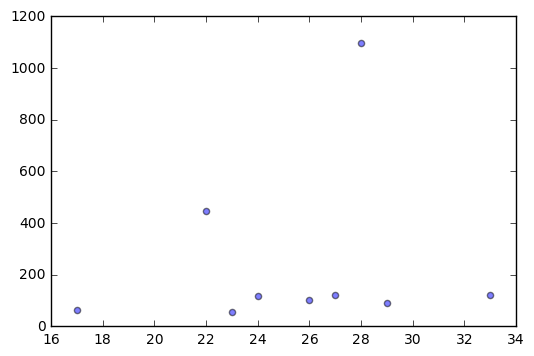

In [15]:
%matplotlib inline
import json
import operator
import numpy as np
import matplotlib.pyplot as plt

# sorted density list
def density(data):
    x = data
    sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
    print sorted_x[:20]

# distribution plot
def distribution(data):
    plt.scatter(data.keys(), data.values(), alpha=0.5)
    plt.show()

# loader
def driver():
    datain = open('dataout.txt','r')

    densdata = {}
    distdata = {}

    # clean the mess I made
    for line in datain:
        parts = line.split('\t')
        temp = parts[1][1:-2].replace('"', '').split(':')
        mrj_val = parts[0].replace('"', '')
        if mrj_val == "mrj_dens":
            densdata[temp[0]]=float(temp[1])
        elif mrj_val == "mrj_dist":
            distdata[int(temp[0])]=int(temp[1])
    
    #Execute density sort
    density(densdata)
    
    #Execute distribution plot
    distribution(distdata)
            
driver()

<a name="2.6">
## 2.6 NLTK Benchmarking
[Back to Table of Contents](#TOC) 

This section examine the output pairs using nltk library.  
For each pair of words, we examine whether one is identified as a synonym of the other by nltk.  
Based on the "hit" data, we compute precision, recall and F1 score of the output.  

**With limited pair in the output, it is possible to run everything within a python script.  
We also prepare a mapreduce job in case the number of pairs increase**

In [16]:
%%writefile NLTKBenchMark.py

import nltk
import json
import numpy as np
from nltk.corpus import wordnet as wn
from mrjob.job import MRJob
from mrjob.step import MRStep

class NLTKBenchMark(MRJob):
    
    def mapper(self, _, lines):
        #parse the output file and identify the pair of words
        pair, avg = lines.split("\t")
        pair = json.loads(pair)
        word1, word2 = pair[0], pair[1]        
        
        hit = 0
        
        #for each word, extract the list of synonyms from nltk corpus, convert to set to remove duplicates
        syn1 = set([l.name() for s in wn.synsets(word1) for l in s.lemmas()])
        syn2 = set([l.name() for s in wn.synsets(word2) for l in s.lemmas()])
        
        #keep track of words that have no synonym using '~nosync'
        if len(syn1) == 0:
            yield '~nosyn', [word1]
        if len(syn2) == 0:
            yield '~nosyn', [word2]
            
        '''
        for each occurence of word, increment the count
        for word A, synset is the number of synonyms of the other word B
        this value is used for calculating recall
        this method becomes confusing/problematic if a word appears multiple times in the final output
        
        if there is a hit for word A, set the hit to 1, and set the hit for the other word B to 0 (to avoid double count)
        if there is not a hit for A and B, set the hit to 0 for both
        '''
        if word2 in syn1:
            yield word2, {'hit':1, 'count':1, 'synset':len(syn1)}
            yield word1, {'hit':0, 'count':1, 'synset':len(syn2)}
        elif word1 in syn2:
            yield word1, {'hit':1, 'count':1, 'synset':len(syn2)}
            yield word2, {'hit':0, 'count':1, 'synset':len(syn1)}
        else:
            yield word1, {'hit':0, 'count':1, 'synset':len(syn2)}
            yield word2, {'hit':0, 'count':1, 'synset':len(syn1)}
        
    def combiner(self, term, values):
        #combine '~nosyn' into a bigger list and yield the list
        if term == '~nosyn':
            nosynList = []
            for value in values:
                nosynList = nosynList+value
            yield term, nosynList
            
        else:
            counters = {'hit':0, 'count':0, 'synset':0}
            for value in values:
                counters['hit'] += value['hit']
                counters['count'] += value['count']
                counters['synset'] = value['synset']
            yield term, counters
        
        
    def reducer_init(self):
        self.plist = []
        self.rlist = []
        self.flist = []
        
    def reducer(self, term, values):
        #yield the final list of words that have no synonym
        if term == '~nosyn':
            nosynList = []
            for value in values:
                nosynList = nosynList+value
            yield term, nosynList
            
        else:
            counters = {'hit':0.0, 'count':0.0, 'synset':0.0}
            precision, recall, F1 = 0,0,0
            for value in values:
                counters['hit'] += value['hit']
                counters['count'] += value['count']
                counters['synset'] = value['synset']
                
            if counters['hit'] > 0 and counters['synset'] > 0:
                precision = float(counters['hit'])/float(counters['count'])
                recall = float(counters['hit'])/float(counters['synset'])
                F1 = 2*precision*recall/(precision+recall)
                
                self.plist.append(precision)
                self.rlist.append(recall)
                self.flist.append(F1)
                yield term, counters
            elif counters['synset'] > 0:
                self.plist.append(precision)
                self.rlist.append(recall)
                self.flist.append(F1)
                yield term, counters
    
    def reducer_final(self):
        #compute the mean of all collected measurements
        yield 'precision', np.mean(self.plist)
        yield 'recall', np.mean(self.rlist)
        yield 'F1', np.mean(self.flist)
        
if __name__ == "__main__":
    NLTKBenchMark.run()

Overwriting NLTKBenchMark.py


In [17]:
!python NLTKBenchMark.py nltk_bench_sample.txt

No configs found; falling back on auto-configuration
Creating temp directory /tmp/NLTKBenchMark.cloudera.20161011.115908.452455
Running step 1 of 1...
Streaming final output from /tmp/NLTKBenchMark.cloudera.20161011.115908.452455/output...
"bad"	{"count": 2.0, "synset": 65, "hit": 0.0}
"candy"	{"count": 1.0, "synset": 8, "hit": 0.0}
"cat"	{"count": 1.0, "synset": 37, "hit": 0.0}
"cotton"	{"count": 1.0, "synset": 5, "hit": 0.0}
"dog"	{"count": 1.0, "synset": 46, "hit": 0.0}
"fairy"	{"count": 1.0, "synset": 9, "hit": 0.0}
"glad"	{"count": 2.0, "synset": 7, "hit": 0.0}
"good"	{"count": 2.0, "synset": 34, "hit": 0.0}
"precision"	0.0
"recall"	0.0
"F1"	0.0
"man"	{"count": 1.0, "synset": 11, "hit": 0.0}
"mario"	{"count": 1.0, "synset": 7, "hit": 0.0}
"pikachu"	{"count": 1.0, "synset": 57, "hit": 0.0}
"tale"	{"count": 1.0, "synset": 16, "hit": 0.0}
"unhappy"	{"count": 1.0, "synset": 10, "hit": 0.0}
"well"	{"count": 1.0, "synset": 65, "hit": 1.0}
"woman"	{"count": 1.0, "synset": 33, "hit": 0.0}

In [18]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    
    return syndict.keys()

hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

## For this part we can use one of three outputs. They are all the same, but were generated differently
# 1. the top 1000 from the full sorted dataset -> sortedSims[:1000]
# 2. the top 1000 from the partial sort aggragate file -> sims2/top1000sims
# 3. the top 1000 from the total order sort file -> head -1000 sims_parts/part-00004

top1000sims = []
with open("nltk_bench_sample.txt","r") as f:
    for line in f.readlines():
        line = line.strip()
        lisst, avg = line.split("\t")
        lisst = eval(lisst)
        lisst.append(avg)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1
    words=line[0:2]
    
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure   
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 1 out of top 10
Number of words without synonyms: 2
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0666666666667
Recall		0.0018018018018
F1		0.00350877192982
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] pikachu
[] mario
